In [1]:
import numpy as np
import cupy as cp
import chainer

import os
import wandb
import cv2
from utils.functions import Bunch
from utils.graphics import render_double, data2img
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
name = '1_elman_100of100-100'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/nsi")
for run in runs:
    if run.name == name:
        run_id = run.id
        args = Bunch(run.config)
        print(run.name, run.id)
        break


# model
from model import ElmanId
idx = np.arange(args.idx_size)
data_idx = idx
model = ElmanId(N=args.N, in_size=args.in_size, idx=idx, feature_size=args.dim, nonlinear='relu-tanh', alpha=0.2, norm=args.norm, bias=True,
                noise_scale=0.0, lr=1e-4, reg=args.reg, coef_neuron=args.coef_neuron, coef_rnn=args.coef_rnn).to_gpu()

# load
for file in os.listdir('./wandb/'):
    if run_id in file:
        model_dir = './wandb/' + file + '/files/model-10.pkl'
        chainer.serializers.load_npz(model_dir, model)
        print("load: " + model_dir)
        break

# data
data = np.load('./data/dim=1_False_B=100_T=1000_N=100.npz')
rs = data['rs']
xs = data['xs']
x0 = data['x0']
vs = data['vs']
us = []

model.init(cp.asarray(rs[:, 0, data_idx]))
for t in trange(args.T):
    u = model.forward(cp.asarray(vs[:, t])).array
    us.append(cp.asnumpy(u))

    # # visualize
    # neural_img = render_double(cp.asnumpy(u[0, :]), rs[0, t, :], bottom=0., top=None, label1='u', label2='r')
    # cv2.imshow("neural", neural_img)
    # cv2.waitKey(0)

us = np.array(us).swapaxes(0, 1)

1_elman_100of100-100 w2q6o8b8
load: ./wandb/run-20221122_040930-w2q6o8b8/files/model-10.pkl


100%|██████████| 1000/1000 [00:00<00:00, 1133.62it/s]


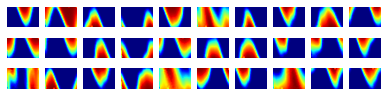

In [19]:
# ratemap
from cns.utils.visualize import calc_ratemap, plot_ratemap

if args.dim == 1:
    vxs = np.concatenate((vs, xs), axis=-1)
    activations = calc_ratemap(r=us, x=vxs, coords=((-5, 5), (0, 2 * np.pi)), resolutions=(4, 10))
elif args.dim == 2:
    activations = calc_ratemap(r=us[:, :, 0:32], x=xs, coords=((-1.1, 1.1), (-1.1, 1.1)), resolutions=(10, 10))
rm_fig = plot_ratemap(activations[:, ...], n_plots=len(activations), width=10)
plt.savefig("{}.png".format(name))

# W

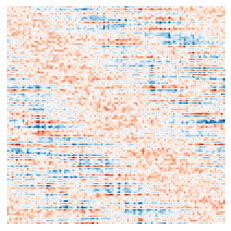

In [170]:
cmap = 'RdBu_r'

W = cp.asnumpy(model.W.array)
b = cp.asnumpy(model.b.array)

plt.tight_layout()
plt.axis('off')
plt.imshow(W, cmap=cmap)
# plt.savefig("{}_W.png".format(name), dpi=300)

plt.imsave('./{}_W.png'.format(name), W, cmap=cmap, dpi=300)

In [135]:
max_x = np.argmax(np.sum(activations[100:, :, :], axis=1), axis=-1)
sort_idx = np.argsort(max_x)[::-1]

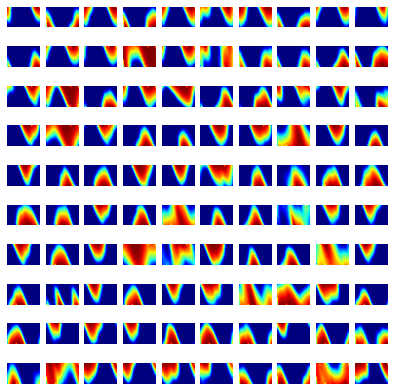

In [124]:
plot_ratemap(activations[100:, ...][sort_idx, ...], n_plots=len(activations), width=10)
plt.show()

In [136]:
W_sort = W.copy()
W_sort[100:, :] = W_sort[100 + sort_idx, :]
W_sort[:, 100:] = W_sort[:, 100 + sort_idx]

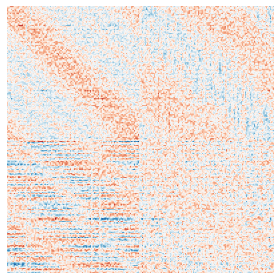

In [167]:
plt.axis('off')
plt.tight_layout()
plt.imshow(W_sort, cmap=cmap)

# plt.savefig('{}_W-sort.png'.format(name), dpi=300)
plt.imsave('./{}_W-sort.png'.format(name), W_sort, cmap=cmap, dpi=300)

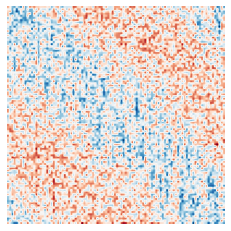

In [168]:
plt.axis('off')
plt.imshow(W_sort[0:100, 100:], cmap='RdBu_r')
# plt.savefig('{}_W-ur.png'.format(name), dpi=300)

plt.imsave('./{}_W-sort-ur.png'.format(name), W_sort[0:100, 100:], cmap=cmap, dpi=300)

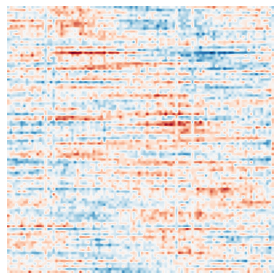

In [163]:
plt.axis('off')

W_sort_prod = W_sort[0:100, 100:] @ W_sort[100:, 0:100]

plt.tight_layout()
plt.imshow(W_sort_prod, cmap='RdBu_r')
# plt.savefig('{}_W-prod.png'.format(name), dpi=300)

# plt.colorbar()

plt.imsave('./{}_W-sort-prod.png'.format(name), W_sort_prod, cmap=cmap)